# Experiment 1 : Embedded Reber Grammar

In [1]:
from MewralLSTM import MewralOldLSTM
import random
import numpy  as np
import matplotlib.pyplot as plt
reber_grammar = {
    -1: [(0, 'B')],           
    0:  [(1, 'T'), (2, 'P')],  
    1:  [(1, 'S'), (3, 'X')],  
    2:  [(2, 'T'), (4, 'V')],  
    3:  [(2, 'X'), (5, 'S')],  
    4:  [(3, 'P'), (5, 'V')],  
    5:  [(None, 'E')]         
}

def generate_reber_string():
    current_node_id = -1
    string=""
    valid_history = []

    while current_node_id!=None:

        possible_moves = reber_grammar[current_node_id]
        valid_chars =  [move[-1] for move in possible_moves]
        valid_history.append(valid_chars)

        next_move = random.choice(possible_moves)

        current_node_id = next_move[0]
        string+=next_move[1]

    return string, valid_history

def generate_embedded_reber_string():
    embedded_string = "B"
    embedded_history = [['B']]
    
    key = random.choice(['T', 'P'])
    embedded_string += key
    embedded_history.append(['T', 'P'])

    inner_string, inner_history = generate_reber_string()
    
    embedded_string += inner_string
    embedded_history.extend(inner_history)

    embedded_string += key
    embedded_history.append([key]) 
    
    embedded_string += "E"
    embedded_history.append(['E'])
    
    return embedded_string, embedded_history

def generate_train_dataset(num_samples = 256, training_datset = None):
    dataset = []
    dataset_histories = []

    existing_set = set(training_datset) if training_datset else set()

    while len(dataset)<(num_samples):
        string, valid_history = generate_embedded_reber_string()

        if string in existing_set:
            continue
            
        if string in dataset:
            continue

        dataset.append(string)
        dataset_histories.append(valid_history)

    return dataset, dataset_histories

chars = sorted(['B', 'T', 'P', 'S', 'X', 'V', 'E'])
char_to_ix = {ch:i for i, ch in enumerate(chars)}


def encode_dataset(dataset, histories, char_to_ix):
    X_list = []
    y_list = []

    vocab_size = len(char_to_ix)

    for i in range(len(dataset)):
        seq_string = dataset[i]
        seq_history = histories[i]

        seq_length = len(seq_string)-1

        x_seq = np.zeros((seq_length, 1, vocab_size))
        y_seq = np.zeros((seq_length, 1, vocab_size))

        for t in range(seq_length):
            char = seq_string[t]
            x_seq[t,0,char_to_ix[char]] = 1.0

            valid_next_chars = seq_history[t+1]

            for next_char in valid_next_chars:
                y_seq[t,0, char_to_ix[next_char]] = 1.0
        
        X_list.append(x_seq)
        y_list.append(y_seq)

    return X_list, y_list

string_dataset, valid_string_histories = generate_train_dataset()
X_train, y_train = encode_dataset(string_dataset, valid_string_histories, char_to_ix)



Epoch 0: Loss = 9.22130
Epoch 20: Loss = 1.55791
Epoch 40: Loss = 0.37904
Epoch 60: Loss = 0.09804
Epoch 80: Loss = 0.02921
Epoch 100: Loss = 0.01925
Epoch 120: Loss = 0.01551
Epoch 140: Loss = 0.01328
Epoch 160: Loss = 0.01168
Epoch 180: Loss = 0.01089
Epoch 200: Loss = 0.01020


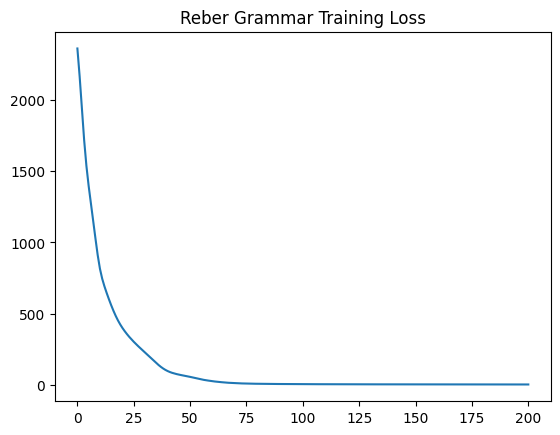

In [ ]:
# Training Loop


#Parameters
INPUT_SIZE = 7
HIDDEN_SIZE = 32
LAYERS = 1
OUTPUT_SIZE = 7

LSTM = MewralOldLSTM(INPUT_SIZE, HIDDEN_SIZE, LAYERS, OUTPUT_SIZE, optimizer="sgd")

EPOCHS = 201
LEARNING_RATE = 0.05

loss_history = []
for epoch in range(EPOCHS):
    total_epoch_loss = 0

    for i in range(len(X_train)):
        x_seq = X_train[i]
        y_seq = y_train[i]
        LSTM.last_batch_short_term_memory = None
        
        loss = LSTM.BPTT(x_seq, y_seq, learning_rate=LEARNING_RATE, loss_mode="sequence", retain_state=False)

        total_epoch_loss +=loss

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {(total_epoch_loss / len(X_train)):.5f}")

    loss_history.append(total_epoch_loss)

        
plt.plot(loss_history)
plt.title("Reber Grammar Training Loss")
plt.show()

In [ ]:
#Testing Accuracy
def test_reber_grammar_accuracy(LSTM, X_test, Y_test):
    print("--- Starting Accuracy Test ---")
    passed_sequences = 0

    for i in range(len(X_test)):
        x_seq = X_test[i]
        y_seq = Y_test[i]
        outputs, hidden, caches = LSTM.forward(x_seq, retain_state=False)
        LSTM.last_batch_short_term_memory = None
        sequence_passed = True
        
        for t in range(len(outputs)):
            pred_raw = outputs[t][0] 
            
            target_vector = y_seq[t][0]
            valid_indices = np.where(target_vector == 1.0)[0]

            invalid_indices = np.where(target_vector == 0.0)[0]
            min_valid_prob = np.min(pred_raw[valid_indices])
            max_invalid_prob = np.max(pred_raw[invalid_indices])

            if min_valid_prob <= max_invalid_prob:
                sequence_passed = False
                break
        
        if sequence_passed:
            passed_sequences +=1
    
    accuracy = passed_sequences/len(X_test)*100
    print(f"Final Accuracy: {accuracy:.2f}% (Sequences Perfectly Predicted)")
    return accuracy

print("-------------Training Set Accuracy-------------")
test_reber_grammar_accuracy(LSTM, X_train, y_train)
string_dataset_test, valid_string_histories_test = generate_train_dataset(training_datset=string_dataset)
X_test, y_test = encode_dataset(string_dataset_test, valid_string_histories_test, char_to_ix)
print("-------------Test Set Accuracy-------------")
test_reber_grammar_accuracy(LSTM, X_test, y_test)

-------------Training Set Accuracy-------------
--- Starting Accuracy Test ---
Final Accuracy: 100.00% (Sequences Perfectly Predicted)
-------------Test Set Accuracy-------------
--- Starting Accuracy Test ---
Final Accuracy: 100.00% (Sequences Perfectly Predicted)


100.0

Epoch 0: Loss = 0.70421
Epoch 20: Loss = 0.04483
Epoch 40: Loss = 0.04353
Epoch 60: Loss = 0.04293
Epoch 80: Loss = 0.04263
Epoch 100: Loss = 0.04247
Epoch 120: Loss = 0.04251
Epoch 140: Loss = 0.04249
Epoch 160: Loss = 0.04236
Epoch 180: Loss = 0.04216
Epoch 200: Loss = 0.04212
Epoch 220: Loss = 0.04208
Epoch 240: Loss = 0.04205
Epoch 260: Loss = 0.04208
Epoch 280: Loss = 0.04208
Epoch 300: Loss = 0.04197
Epoch 320: Loss = 0.04192
Epoch 340: Loss = 0.04188
Epoch 360: Loss = 0.04179
Epoch 380: Loss = 0.04172
Epoch 400: Loss = 0.04168
Epoch 420: Loss = 0.04165
Epoch 440: Loss = 0.04167
Epoch 460: Loss = 0.04171
Epoch 480: Loss = 0.04175
Epoch 500: Loss = 0.04180
Epoch 520: Loss = 0.04183
Epoch 540: Loss = 0.04186
Epoch 560: Loss = 0.04194
Epoch 580: Loss = 0.04202
Epoch 600: Loss = 0.04207
Epoch 620: Loss = 0.04213
Epoch 640: Loss = 0.04222
Epoch 660: Loss = 0.04232
Epoch 680: Loss = 0.04243
Epoch 700: Loss = 0.04250
Epoch 720: Loss = 0.04272
Epoch 740: Loss = 0.04332
Epoch 760: Loss = 

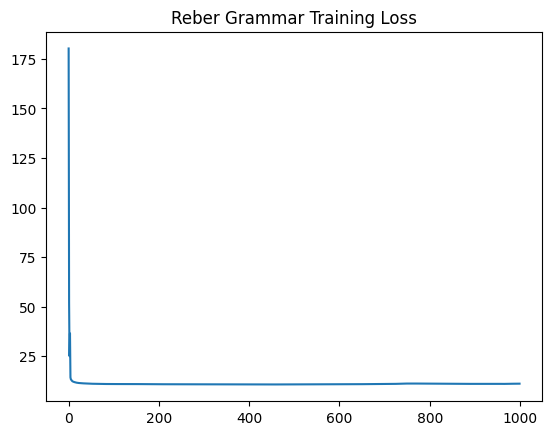

In [ ]:
# Comparison with Standard RNN with BPTT
from StandardRNN import RecurrentMewralNet

INPUT_SIZE = 7
HIDDEN_SIZE = 32
LAYERS = 1
OUTPUT_SIZE = 7

RNN = RecurrentMewralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, initialzation="random")

EPOCHS = 1000
LEARNING_RATE = 0.05

loss_history = []
for epoch in range(EPOCHS):
    total_epoch_loss = 0

    for i in range(len(X_train)):
        x_seq = X_train[i]
        y_seq = y_train[i]
        
        loss = RNN.BPTT(x_seq, y_seq, learning_rate=LEARNING_RATE)

        total_epoch_loss +=loss

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {(total_epoch_loss / len(X_train)):.5f}")

    loss_history.append(total_epoch_loss)

        
plt.plot(loss_history)
plt.title("Reber Grammar Training Loss")
plt.show()


In [14]:
def test_reber_grammar_accuracy(model:RecurrentMewralNet, X_test, Y_test):
    print("--- Starting Accuracy Test ---")
    passed_sequences = 0

    for i in range(len(X_test)):
        x_seq = X_test[i]
        y_seq = Y_test[i]
        outputs, hidden = model.forward(x_seq)
        sequence_passed = True
        
        for t in range(len(outputs)):
            pred_raw = outputs[t][0] 
            
            target_vector = y_seq[t][0]
            valid_indices = np.where(target_vector == 1.0)[0]

            invalid_indices = np.where(target_vector == 0.0)[0]
            min_valid_prob = np.min(pred_raw[valid_indices])
            max_invalid_prob = np.max(pred_raw[invalid_indices])

            if min_valid_prob <= max_invalid_prob:
                sequence_passed = False
                break
        
        if sequence_passed:
            passed_sequences +=1
    
    accuracy = passed_sequences/len(X_test)*100
    print(f"Final Accuracy: {accuracy:.2f}% (Sequences Perfectly Predicted)")
    return accuracy

print("-------------Training Set Accuracy-------------")
test_reber_grammar_accuracy(RNN, X_train, y_train)
string_dataset_test, valid_string_histories_test = generate_train_dataset(training_datset=string_dataset)
X_test, y_test = encode_dataset(string_dataset_test, valid_string_histories_test, char_to_ix)
print("-------------Test Set Accuracy-------------")
test_reber_grammar_accuracy(RNN, X_test, y_test)

-------------Training Set Accuracy-------------
--- Starting Accuracy Test ---
Final Accuracy: 48.83% (Sequences Perfectly Predicted)
-------------Test Set Accuracy-------------
--- Starting Accuracy Test ---
Final Accuracy: 48.44% (Sequences Perfectly Predicted)


48.4375